In [129]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer,cosine_distance
import numpy as np
from sklearn import mixture

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc,precision_recall_curve

from sklearn.svm import SVC

In [130]:
headers = ({'User-Agent':
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
            AppleWebKit/537.36 (KHTML, like Gecko) \
            Chrome/90.0.4430.212 Safari/537.36',
            'Accept-Language': 'en-US, en;q=0.5'})

def getReviews(page_url):        
           

        last_page = 6;
        
        rows= []
        for page in range(1,last_page):
            page_url_fin = page_url % page
            soup = BeautifulSoup(requests.get(page_url_fin, headers=headers).content, 'html.parser') 
            review_all =soup.find("div",class_="a-section a-spacing-none review-views celwidget")

            for idx, div in enumerate(review_all):
                
                name=None
                rating=None
                date=None
                review=None
                     
        
                p_name=div.select("span.a-profile-name")
                if p_name!=[]:
                    name=p_name[0].get_text() 
        
                p_review= div.select("span.review-text-content")
                if p_review!=[]:
                    review= p_review[0].get_text().replace('\n', '').strip() 
                
                p_rating= div.select("span.a-icon-alt")
                if p_rating!=[]:
                    rating= p_rating[0].get_text().replace('.0 out of 5 stars', '').strip()
                    
                p_date= div.select("span.review-date")
                if p_date!=[]:
                    date= p_date[0].get_text().replace('Reviewed in the United States on ', '').strip()
                    
                
        
                rows.append((name,date,review,rating))

        reviews = pd.DataFrame(rows, columns=('Name','Date','Review','Rating',))

        return reviews    


In [131]:
# In this section we are scrapping reviews from Amazon.com for Iphone 12, Iphone 12 pro and Iphone 12 pro max 
# We will be creating a DataFrame with Name, Date , Review and Rating

page_url_1 = "https://www.amazon.com/Apple-iPhone-Graphite-Carrier-Subscription/product-reviews/B08L5NHRWN/ref=cm_cr_getr_d_paging_btm_next_3?ie=UTF8&reviewerType=all_reviews&pageNumber=%d"
reviews_1=getReviews(page_url_1)

page_url_2 ="https://www.amazon.com/Apple-iPhone-Locked-Carrier-Subscription/product-reviews/B08L5P7DYY/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=%d"
reviews_2=getReviews(page_url_2)

page_url_3 ="https://www.amazon.com/Apple-iPhone-Pro-128GB-Graphite/product-reviews/B08PL89SJS/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=%d"
reviews_3=getReviews(page_url_3)


reviews = reviews_1.append(reviews_2, ignore_index=True)

reviews = reviews.append(reviews_3, ignore_index=True)

reviews = reviews[reviews.Name.notnull()]


reviews['Rating'] = reviews['Rating'].astype(int)

reviews.reset_index(drop=True, inplace=True)

reviews

,Name,Date,Review,Rating
0,Honest Reviewer,"October 23, 2020",Pros:__________• I absolutely love the design ...,4
1,Ioana B.,"November 14, 2020",VERY DISAPPOINTED . My boyfriend bought 2 iPho...,1
2,Little teddy,"October 28, 2020",almost no one used cricket. this is really dumb,1
3,Kevin,"October 28, 2020",It is locked and stilll Amazon sell it at fuuu...,1
4,Last_Avenger,"November 4, 2020",The media could not be loaded. ...,4
...,...,...,...,...
120,Ryan,"March 23, 2021",Came with 100% battery capacity and no scratch...,5
121,Morales Lizzetti Luis Alberto,"June 4, 2021",El mejor producto,5
122,April,"June 17, 2021",Good product so far,5
123,Manuel Espinoza,"July 14, 2021",en perfectos estados,5


In [132]:
# We are diving the dataset into two lists Positive and Negative for further Sentimental Analysis


positive_list = reviews[reviews.Rating > 2]
negative_list = reviews[reviews.Rating < 3]

#positive_list.shape
#negative_list.shape

In [133]:
def word_list(positive_negative_list):
    review_list= []
    for x in range(len(positive_negative_list.index)):
        review_list.append(positive_negative_list.values[x][2])
    
    text = ". ".join(review_list).lower()
    
    return text


In [134]:
positive_word_list = word_list(positive_list)

negative_word_list = word_list(negative_list)


In [135]:
import nltk, re, json, string
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from nltk.corpus import stopwords
import spacy
from nltk.probability import FreqDist


def most_common_words(text, K,speech):
    stop_words = stopwords.words('english')
   
    tokens=[token.strip() \
            for token in nltk.word_tokenize(text.lower()) \
            if token.strip() not in stop_words and\
               token.strip() not in string.punctuation]
    
    
    tagged_tokens= nltk.pos_tag(tokens)
    
    #print(tagged_tokens)
    
    words = [token[0] for token in tagged_tokens if token[1] in [speech]]

    fdist=nltk.FreqDist(words) 
    
    result = fdist.most_common(K)
    
    return result

In [136]:
# We are analysing the Text for most frequent words and specifications details for positive reviews

print(most_common_words(positive_word_list,20,'NNS'))

print(most_common_words(positive_word_list,20,'NN'))

print(most_common_words(positive_word_list,20,'JJ'))

print(most_common_words(positive_word_list,20,'RB'))


[('phones', 9), ('years', 9), ('people', 9), ('cameras', 6), ('features', 6), ('colors', 5), ('scratches', 5), ('looks', 5), ('iphones', 4), ('accessories', 4), ('feet', 4), ('magnets', 4), ('screens', 4), ('stars', 4), ('calls', 4), ('pixels', 3), ('photos', 3), ('issues', 3), ('cables', 3), ('data', 3)]
[('phone', 100), ('iphone', 49), ('apple', 41), ('’', 25), ('battery', 24), ('charger', 19), ('camera', 18), ('screen', 16), ('box', 14), ('life', 13), ('time', 12), ('use', 9), ('feature', 8), ('software', 8), ('case', 7), ('night', 7), ('difference', 7), ('lot', 7), ('love', 7), ('area', 6)]
[('new', 29), ('great', 24), ('good', 16), ('pro', 15), ('’', 14), ('little', 12), ('screen', 8), ('previous', 6), ('worth', 6), ('able', 6), ('much', 6), ('first', 5), ('main', 5), ('overall', 5), ('many', 5), ('upgrade', 5), ('..', 5), ('fantastic', 4), ('usb', 4), ('whole', 4)]
[('still', 19), ("n't", 14), ('also', 12), ('back', 12), ('well', 10), ('even', 8), ('really', 8), ('iphone', 7), ('

In [137]:
# We are analysing the Text for most frequent words and specifications details for negative reviews

print(most_common_words(negative_word_list,20,'NNS'))

print(most_common_words(negative_word_list,20,'NN'))

print(most_common_words(negative_word_list,20,'JJ'))

print(most_common_words(positive_word_list,20,'RB'))


[('years', 4), ('iphones', 3), ('issues', 3), ('phones', 3), ('people', 3), ('customers', 2), ('costs', 2), ('headphones', 2), ('dollars', 2), ('accessories', 2), ('sucks', 2), ('bezels', 2), ('things', 2), ('days', 2), ('cards', 2), ('diagnostics', 2), ('besides', 2), ('earpods', 2), ('times', 2), ('notes', 2)]
[('phone', 60), ('apple', 32), ('iphone', 20), ('cricket', 10), ('company', 7), ('time', 7), ('box', 6), ('product', 6), ('get', 6), ('money', 6), ('charger', 5), ('’', 5), ('thing', 5), ('everything', 5), ('amazon', 4), ('charge', 4), ('device', 4), ('cable', 4), ('screen', 4), ('update', 4)]
[('new', 13), ('first', 5), ('pro', 4), ('’', 4), ('good', 4), ('able', 3), ('screen', 3), ('upgrade', 3), ('ive', 3), ('disappointed', 2), ('last', 2), ('big', 2), ('full', 2), ('daily', 2), ('ridiculous', 2), ('lol', 2), ('nice', 2), ('different', 2), ('much', 2), ('next', 2)]
[('still', 19), ("n't", 14), ('also', 12), ('back', 12), ('well', 10), ('even', 8), ('really', 8), ('iphone', 7

(-0.5, 799.5, 799.5, -0.5)

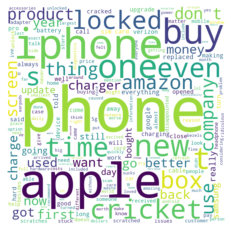

(-0.5, 799.5, 799.5, -0.5)

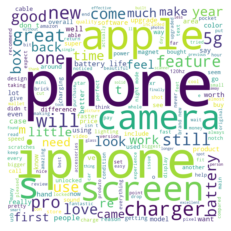

In [139]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image


wordcloud_negative = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(negative_word_list)

wordcloud_positive = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(positive_word_list)

plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.show()


#img = wordcloud.to_image()
#img.show()

In [140]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

sentiment_positive = sid.polarity_scores(positive_word_list)

sentiment_negative = sid.polarity_scores(negative_word_list)

print(sentiment_positive)
print(sentiment_negative)

{'neg': 0.054, 'neu': 0.767, 'pos': 0.179, 'compound': 1.0}
{'neg': 0.101, 'neu': 0.809, 'pos': 0.091, 'compound': -0.9606}


In [141]:
from gensim.models import word2vec
import logging
import pandas as pd

stop_words = stopwords.words('english')

sentences=[ [token.strip(string.punctuation).strip() \
             for token in nltk.word_tokenize(doc.lower()) \
                 if token not in string.punctuation and \
                 token.strip() not in stop_words and \
                 len(token.strip(string.punctuation).strip())>=2]\
             for doc in reviews["Review"]]

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', \
                    level=logging.INFO)

In [142]:
wv_model = word2vec.Word2Vec(sentences, \
            min_count=5, vector_size=200, \
            window=5, workers=4 )

2021-12-05 21:43:18,638 : INFO : collecting all words and their counts
2021-12-05 21:43:18,639 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-12-05 21:43:18,644 : INFO : collected 1649 word types from a corpus of 4334 raw words and 125 sentences
2021-12-05 21:43:18,645 : INFO : Creating a fresh vocabulary
2021-12-05 21:43:18,647 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 182 unique words (11.036992116434202%% of original 1649, drops 1467)', 'datetime': '2021-12-05T21:43:18.647572', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2021-12-05 21:43:18,648 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 2125 word corpus (49.03091832025842%% of original 4334, drops 2209)', 'datetime': '2021-12-05T21:43:18.648564', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.

In [144]:
print("Top 5 words similar to word 'screen'")
wv_model.wv.most_similar('screen', topn=5)

Top 5 words similar to word 'screen'


[('phone', 0.5620959401130676),
 ('life', 0.5063528418540955),
 ('want', 0.48739054799079895),
 ('come', 0.4805005192756653),
 ('get', 0.47618192434310913)]

In [145]:
reviews['Label'] = reviews['Rating'].apply(lambda x: 0 if x <= 2 else 1)

train = reviews[:90]
test = reviews[90:]

train_text = train["Review"]
test_label = test["Label"]
test_text = test["Review"]

train.head()



,Name,Date,Review,Rating,Label
0,Honest Reviewer,"October 23, 2020",Pros:__________• I absolutely love the design ...,4,1
1,Ioana B.,"November 14, 2020",VERY DISAPPOINTED . My boyfriend bought 2 iPho...,1,0
2,Little teddy,"October 28, 2020",almost no one used cricket. this is really dumb,1,0
3,Kevin,"October 28, 2020",It is locked and stilll Amazon sell it at fuuu...,1,0
4,Last_Avenger,"November 4, 2020",The media could not be loaded. ...,4,1


In [146]:
tfidf_vect = TfidfVectorizer(min_df=1, stop_words='english')
    
dtm= tfidf_vect.fit_transform(train_text)
    
num_clusters=2

clusterer = KMeansClusterer(num_clusters, \
                                cosine_distance, \
                                repeats=20)

clusters = clusterer.cluster(dtm.toarray(), \
                             assign_clusters=True)
test_dtm = tfidf_vect.transform(test_text)
 
predicted = [clusterer.classify(v) for v in test_dtm.toarray()]



confusion_df = pd.DataFrame(list(zip(test_label.values, predicted)),\
                                columns = ["label", "cluster"])
    
confusion_df_fin = pd.crosstab( index=confusion_df.cluster, columns=confusion_df.label)



cluster_dict={0:1,1:0}


predicted_target=[cluster_dict[i] \
                      for i in predicted]

print(metrics.classification_report\
     (test_label, predicted))
    

              precision    recall  f1-score   support

           0       0.12      0.14      0.13         7
           1       0.78      0.75      0.76        28

    accuracy                           0.63        35
   macro avg       0.45      0.45      0.45        35
weighted avg       0.65      0.63      0.64        35



C:\Users\sanju\anaconda3\lib\site-packages\nltk\cluster\util.py:131: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


In [147]:
def create_model_final(train_docs, train_y, test_docs, test_y,
              model_type, stop_words, min_df,max_df,ngram_range, print_result, algorithm_para):
    
    vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=min_df, max_df = max_df, ngram_range = ngram_range)
    train_docs = vectorizer.fit_transform(train_docs)
    
    if model_type == 'svm':
        clf = svm.LinearSVC().fit(train_docs, train_y)
        test_docs = vectorizer.transform(test_docs)
        predicted=clf.predict(test_docs)
        print(classification_report(test_y, predicted))
        
        model = SVC(kernel="linear", probability=True)
        model.fit(train_docs, train_y)

        decision_scores = model.decision_function(test_docs)
        fpr, tpr, thresholds = roc_curve(test_y, decision_scores,pos_label=1)
        auc_score = auc(fpr, tpr)
        precision, recall, thresholds = precision_recall_curve(test_y, decision_scores,pos_label=1)
        prc_score = auc(recall, precision) 
        
        print("AUC: {:.2%}".format(auc(fpr, tpr)), " PRC: {:.2%}".format(auc(recall, precision)))
        
        plt.figure();
        plt.plot(fpr, tpr, color='darkorange', lw=2);
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
        plt.xlim([0.0, 1.0]);
        plt.ylim([0.0, 1.05]);
        plt.xlabel('False Positive Rate');
        plt.ylabel('True Positive Rate');
        plt.title('AUC of SVM');
        plt.show();

        plt.figure();
        plt.plot(recall, precision, color='darkorange', lw=2);
        plt.xlim([0.0, 1.0]);
        plt.ylim([0.0, 1.05]);
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('PRC of SVM');
        plt.show();
    
         
        
    return auc_score, prc_score

              precision    recall  f1-score   support

           0       0.43      0.43      0.43         7
           1       0.86      0.86      0.86        28

    accuracy                           0.77        35
   macro avg       0.64      0.64      0.64        35
weighted avg       0.77      0.77      0.77        35

AUC: 75.51%  PRC: 91.73%


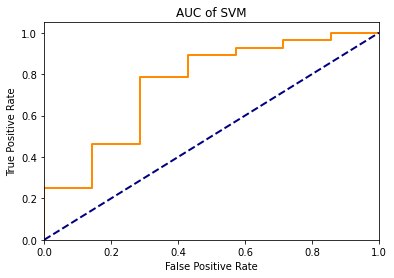

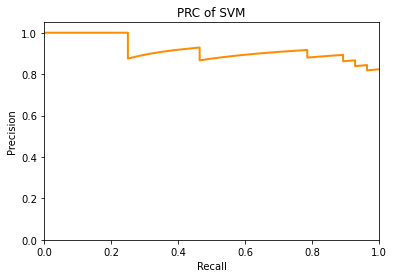

In [148]:
auc_score, prc_socre = create_model_final(train["Review"], train["Label"], test["Review"], test["Label"], \
          model_type='svm', stop_words = None, min_df =2, max_df =0.75 ,ngram_range=(1, 2), print_result=True, algorithm_para=0.3)